In [1]:
from __future__ import annotations

import sys
sys.path.append("/media/wdp/disk4/git/noiseba/src")  # 添加 src 到模块搜索路径
import numpy as np
import datetime
import matplotlib.pyplot as plt

from scipy.fft import next_fast_len
from pathlib import Path
from obspy import read, Stream
from noiseba.preprocessing import batch_process, get_ccf_parallel, write_ccf_parallel, read_coord, stack_ccf
from noiseba.utils import plot_ccf

from noiseba.dispersion import fj_spectra, park, radon

# 1. Preprocess seismic data
- demean, detrend, remove instrment response (optional),  filter, decimiate

In [ ]:
st = read(r'/media/wdp/disk4/site1_line1/data/453000030Z.sac')
start_time = st[0].stats.starttime + datetime.timedelta(minutes=0)
end_time = st[0].stats.endtime

input_dir = Path(r'/media/wdp/disk4/site1_line1/reef/pre_4.13')
out_dir = Path(r'./pre_data')

config = {
    "input_dir": input_dir,
    "output_dir": out_dir,
    # "target_rate": 100,       # decimate smapling rate
    # "freq_min": 1,            # lower filter
    # "freq_max": 45,           # upper filter
    "start_time": start_time, # cut begin
    "end_time": end_time,     # cut end
    "max_workers": 36         # used cpu cores
}

batch_process(**config)

# st1  = read('./pre_gate_data/453000036.N.sac')
# print('Raw sampling rate:', st[0].stats.sampling_rate)
# print('Sampling rate:', st1[0].stats.sampling_rate, '\n')

Reading...
---------------Processing 20 Trace-----------------




Processing traces: 100%|██████████| 20/20 [00:01<00:00, 16.27it/s]



-------------------------Done-----------------------------------


# 2. Compute cross correlation function

In [2]:
input_dir = "/media/wdp/disk4/site1_line1/output/reef1/*.Z.sac"
output_dir = Path('./CCF_ZZ')

st = read(input_dir)
st.detrend(type='demean')
st.detrend(type='linear')

coord = read_coord('/media/wdp/disk4/site1_line1/reef/pre_4.11/xy.txt')
operator = np.ones(10) / 10
dt = round(st[0].stats.delta, 4)
win_sec = 60 # time window to compute ccf
win_len = next_fast_len(int(win_sec / dt)) # window length in points
step = int(0.5 * win_len) # overlap between windows
freq_min = 1
freq_max = 40
cor_time_begin = -4  # ccf start time in seconds
cor_time_end = 4

ccf_dict, ccf_distance = get_ccf_parallel(
    stream=st,
    operator=operator,
    taper=0.05,
    win_len=win_len,
    step=step,
    coord=coord,
    cor_time_begin=cor_time_begin,
    cor_time_end=cor_time_end,
    n_jobs=36,
)


Computing CCFs...: 100%|██████████| 630/630 [00:01<00:00, 324.42it/s]


In [ ]:
# %matplotlib qt
# fig, ax = plt.subplots(1,1, figsize=(8,6))
# plot_ccf(ccf_dict, ccf_distance, cor_time_begin, 0.01, 0.5, axes = ax)

350 450


In [ ]:
write_ccf_parallel(ccf_dict, ccf_distance, 
            output_dir=output_dir, 
            freq_min=freq_min, 
            freq_max=freq_max, 
            dt=dt, 
            start_time=cor_time_begin,
            method='pws', 
            nu=2.0,
            n_jobs=36)
# in command line, write python plot_ccf.py ./CCF

# 3. calculate Dispersion Spectrum

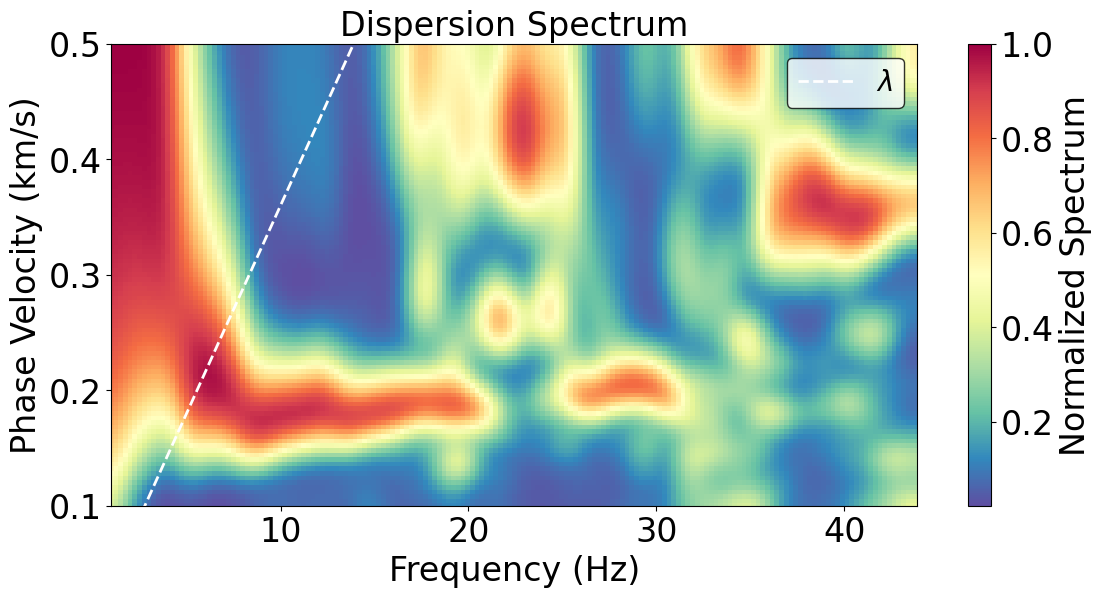

In [6]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'both',
}

park('./CCF_ZZ', **config)

Solving frequencies: 100%|██████████| 91/91 [00:00<00:00, 30299.41it/s]


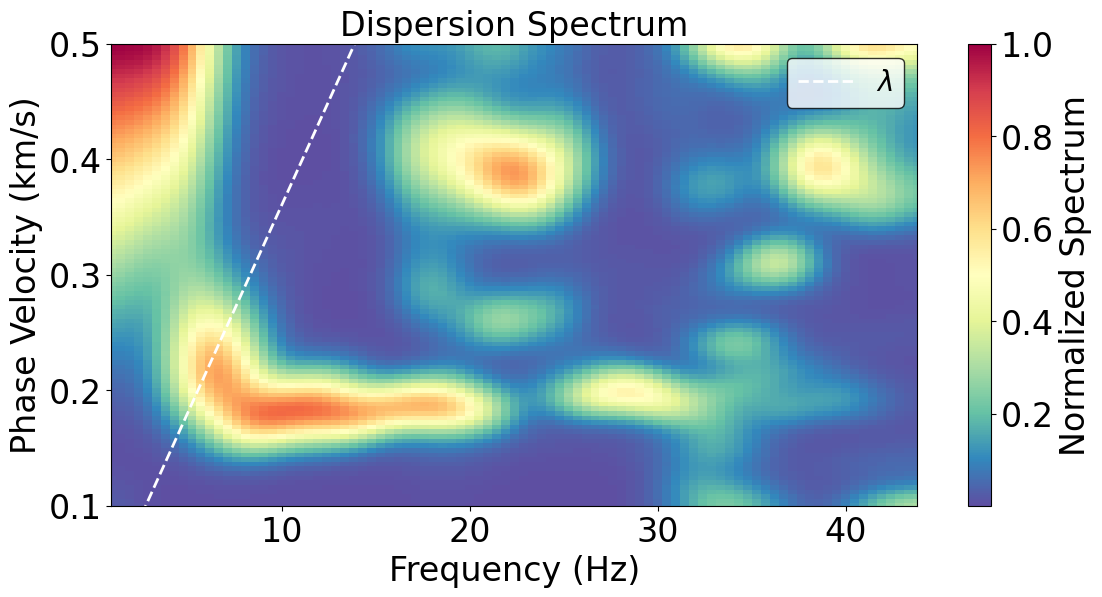

In [5]:
config = {
    'freq_min': 1,
    'freq_max': 40,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 101,
    'part': 'both',
}

extra = {'maxiter': 100, 'method': 'L1', 'tol': 1e-2, 'reg_lambda': 10} | config

radon('./CCF_ZZ', **extra)

### You should install CC-Fj first and then run the cell below, click https://github.com/ColinLii/CC-FJpy

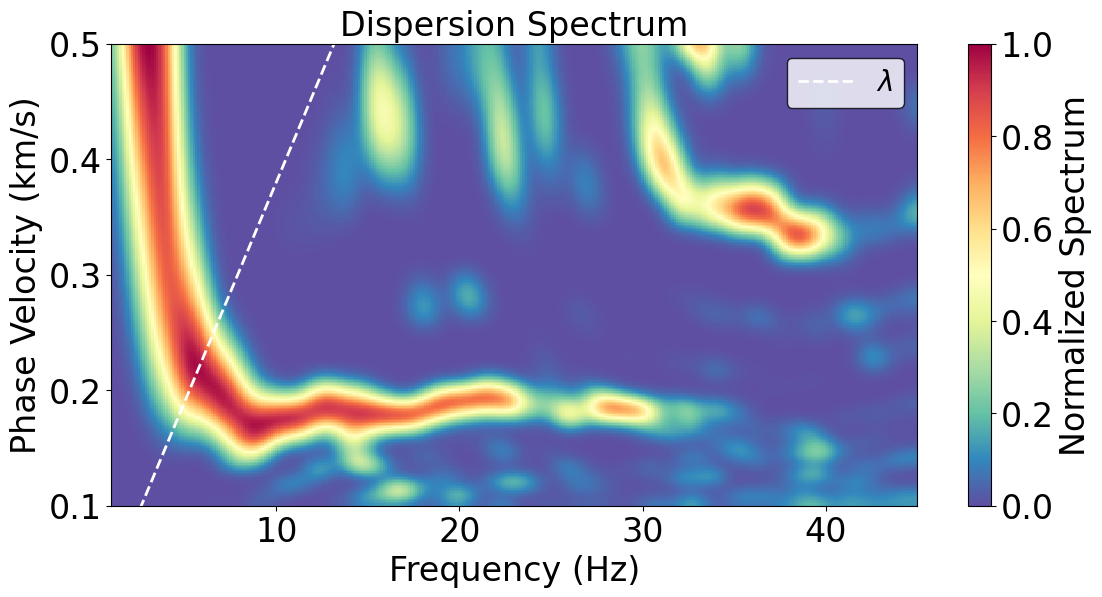

In [3]:
config = {
    'freq_min': 1,
    'freq_max': 45,
    'time_window': 15,
    'vel_min': 100,
    'vel_max': 500,
    'num_vel': 301,
    'njobs': 36,
}
fj_spectra('./CCF_ZZ', config)